# Goodreads Books Reviews

**Authors: Tilova, Calvin, Clement**

---


### Data Dictionary For This Notebook:

---
| Column | Description                                  |Data Type|
|-------|--------------------------------------------|-------|
| rating (**Dependant Variable**)| Rating between 0-5 | int |
| review_text | The book review           | object |

## Table of Contents

---

1. Decision Tree
2. Random Forest
3. XgBoost

**Importing Libraries**

In [27]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#sk-learn text preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# modelling
from sklearn.tree import DecisionTreeClassifier

#model metrics
from sklearn.metrics import f1_score, classification_report

# ignores the filter warnings
import warnings
warnings.filterwarnings('ignore')

<a id = 'wrangle'></a>

### 1. Data Wrangling
---
Loading the CSVs files.

In [11]:
df_train = pd.read_csv('../data/goodreads_train.csv')

# First 5 rows of dataset
df_train.head()

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1
1,8842281e1d1347389f2ab93d60773d4d,16981,a5d2c3628987712d0e05c4f90798eb67,3,Recommended by Don Katz. Avail for free in Dec...,Mon Dec 05 10:46:44 -0800 2016,Wed Mar 22 11:37:04 -0700 2017,NaN,NaN,1,0
2,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,3,"A fun, fast paced science fiction thriller. I ...",Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017,22,0
3,8842281e1d1347389f2ab93d60773d4d,27161156,ced5675e55cd9d38a524743f5c40996e,0,Recommended reading to understand what is goin...,Wed Nov 09 17:37:04 -0800 2016,Wed Nov 09 17:38:20 -0800 2016,NaN,NaN,5,1
4,8842281e1d1347389f2ab93d60773d4d,25884323,332732725863131279a8e345b63ac33e,4,"I really enjoyed this book, and there is a lot...",Mon Apr 25 09:31:23 -0700 2016,Mon Apr 25 09:31:23 -0700 2016,Sun Jun 26 00:00:00 -0700 2016,Sat May 28 00:00:00 -0700 2016,9,1


In [12]:
df_train.drop(['user_id', 'book_id', 'review_id'], axis=1, inplace=True)

# sanity check
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   rating        900000 non-null  int64 
 1   review_text   900000 non-null  object
 2   date_added    900000 non-null  object
 3   date_updated  900000 non-null  object
 4   read_at       808234 non-null  object
 5   started_at    625703 non-null  object
 6   n_votes       900000 non-null  int64 
 7   n_comments    900000 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 54.9+ MB


### Text preprocessing

In [13]:
X = df_train['review_text']
y = df_train['rating']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
X_train.shape, X_test.shape

((630000,), (270000,))

In [15]:
# Initialize CountVectorizer
bow = CountVectorizer(stop_words='english', max_features=500)

# Fit and transform the review columns
X_train_vectorized = bow.fit_transform(X_train)
X_test_vectorized = bow.transform(X_test)

In [16]:
# convert sparse matrix into dataframe
# Source(https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sparse.from_spmatrix.html)
X_train_dense = pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=bow.get_feature_names_out()).sparse.to_dense()
X_test_dense = pd.DataFrame.sparse.from_spmatrix(X_test_vectorized, columns=bow.get_feature_names_out()).sparse.to_dense()

# First 5 rows of training data
X_train_dense.head()

,able,absolutely,action,actual,actually,admit,adult,age,ago,amazing,...,write,writing,written,wrong,ya,yeah,year,years,yes,young
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0


### Decision Tree

Let's instantiate Decision Tree

In [20]:
dt = DecisionTreeClassifier()

dt.fit(X_train_dense, y_train)

print(f"Train score: {dt.score(X_train_dense, y_train)}")
print(f"Test score: {dt.score(X_test_dense, y_test)}")

Train score: 0.9712968253968254
Test score: 0.35835555555555554


Train score is good. We can see there's a heavy overfit between the train and test scores. Let's visualize the max_depth to see where it overfits. 

In [21]:
max_depth = [10, 20, 30, 40, 50]
train_scores = []
test_scores = []

for i in max_depth:
    dt = DecisionTreeClassifier(max_depth=i)
    dt.fit(X_train_dense, y_train)

    train_scores.append(dt.score(X_train_dense, y_train))
    test_scores.append(dt.score(X_test_dense, y_test))

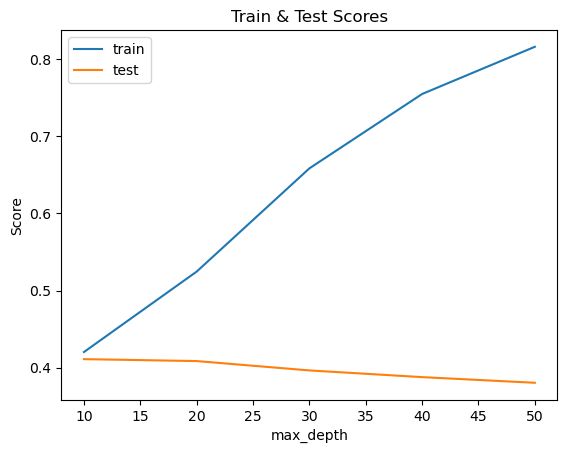

In [24]:
plt.figure()
plt.plot(max_depth, train_scores, label='train')
plt.plot(max_depth, test_scores, label='test')
plt.title('Train & Test Scores')
plt.xlabel('max_depth')
plt.ylabel('Score')
plt.legend()
plt.show()

In [28]:
max_depth = [5, 10, 15, 20]
train_scores = []
test_scores = []
f1_scores = []

for i in max_depth:
    dt = DecisionTreeClassifier(max_depth=i)
    dt.fit(X_train_dense, y_train)

    train_scores.append(dt.score(X_train_dense, y_train))
    test_scores.append(dt.score(X_test_dense, y_test))
    
    y_pred = dt.predict(X_test_dense)
    f1_scores.append(f1_score(y_test, y_pred, average='micro'))

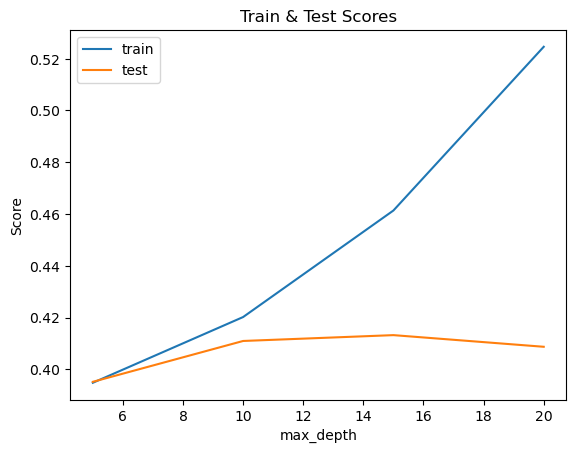

In [30]:
plt.figure()
plt.plot(max_depth, train_scores, label='train')
plt.plot(max_depth, test_scores, label='test')
plt.title('Train & Test Scores')
plt.xlabel('max_depth')
plt.ylabel('Score')
plt.legend()
plt.show()

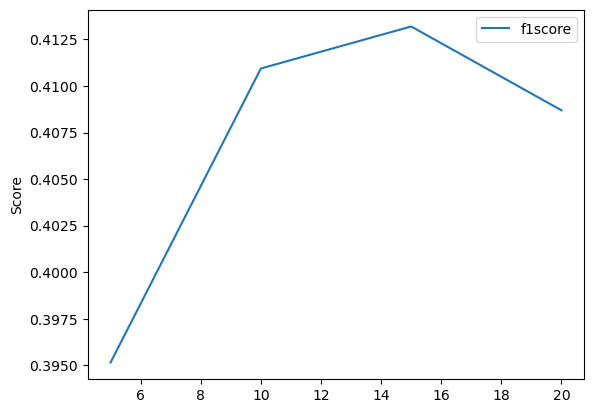

In [31]:
plt.figure()
plt.plot(max_depth, f1_scores, label='f1score')
plt.ylabel('Score')
plt.legend()
plt.show()